In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, timezone
import glob
import os
from tqdm.notebook import tqdm
from Helpers import extract_metadata 

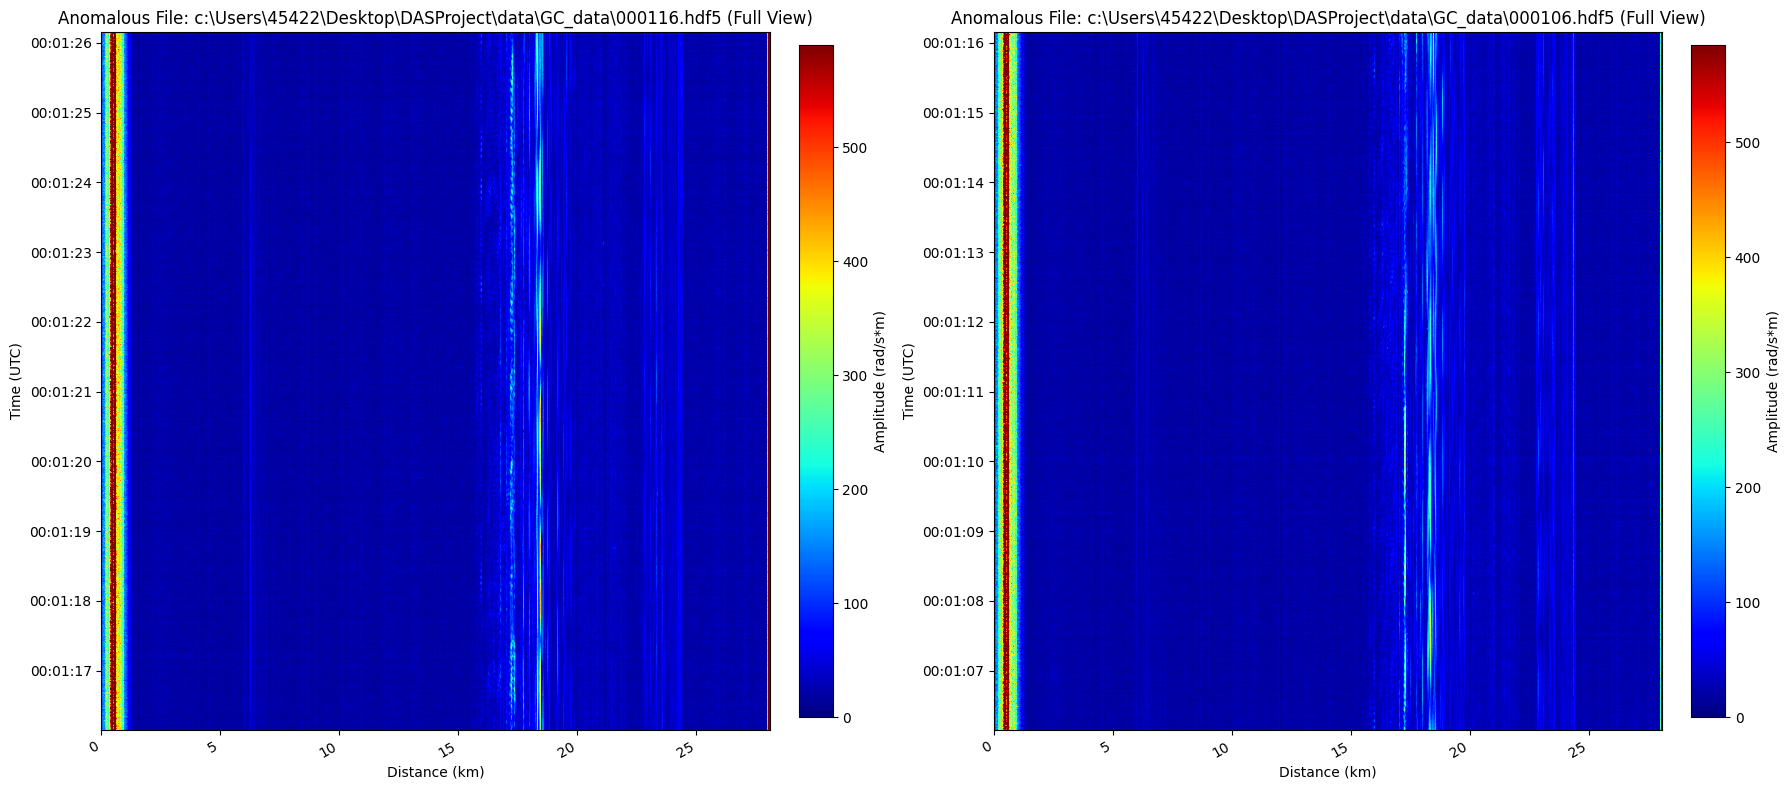

In [5]:
# Define the directory and relevant file names
directory = "data/GC_data"
anomalous_basenames = ['000116.hdf5', '000106.hdf5']  # The two most anomalous files

# Build absolute paths so extract_metadata always receives a full path
anomalous_files = [os.path.abspath(os.path.join(directory, bn)) for bn in anomalous_basenames]

# Quick existence check
for p in anomalous_files:
    if not os.path.exists(p):
        print(f"Warning: file not found: {p}")

# --- Configuration matching Step 1 ---
# These must match the preprocessing used for the model input
dmin_km = 0
dmax_km = 30 
CHANNEL_STEP = 2        # Sampling every second channel
SAMPLE_STEP = 1         # Temporal downsampling factor (no temporal downsampling applied)
dmin_km, dmax_km = 0, 30 
# Ensure we call extract_metadata with a full path and get dx (meters per channel)
first_path = anomalous_files[0]
dx = extract_metadata(first_path)[2]  # Get actual dx

# --- Plotting Function ---

def plot_file_spectrogram(file_name, ax):
    """Loads, processes, and plots the full spectrogram for a single file."""
    file_path = os.path.join(directory, file_name)
    
    if not os.path.exists(file_path):
        ax.set_title(f"File Not Found: {file_name}")
        ax.axis('off')
        return

    # 1. Load Data and Metadata
    start_time, dt, _, channels_raw, num_samples_raw = extract_metadata(file_path)
    
    with h5py.File(file_path, 'r') as f:
        data_raw = f['data'][:]
    
    # 2. Apply Masking/Downsampling (same as in Notebook 1)
    distance_array_m = channels_raw * dx
    distance_array_km = distance_array_m / 1000
    dist_mask = (distance_array_km >= dmin_km) & (distance_array_km <= dmax_km)
    
    # Apply spatial mask and downsampling
    combined_data = data_raw[::SAMPLE_STEP, dist_mask][:, ::CHANNEL_STEP]
    
    # Create distance axis for plotting
    distances = distance_array_km[dist_mask][::CHANNEL_STEP]

    # 3. Create Time Axis
    file_start_datetime = datetime.fromtimestamp(start_time, tz=timezone.utc)
    num_samples = combined_data.shape[0]
    
    # Recalculate duration/time deltas using the actual SAMPLE_STEP
    time_deltas = np.arange(0, num_samples) * (dt * SAMPLE_STEP)
    time_axis = [file_start_datetime + timedelta(seconds=float(t)) for t in time_deltas]

    # 4. Determine VMAX (for visual clarity)
    # Using 99th percentile across the whole file data
    vmax_amp = np.percentile(np.abs(combined_data), 99)

    # 5. Plotting
    
    # Set extent with distances increasing from bottom to top
    img = ax.imshow(np.abs(combined_data),
                aspect='auto',
                extent=[distances[0], distances[-1],
                        mdates.date2num(time_axis[0]),
                        mdates.date2num(time_axis[-1])],
                cmap='jet',
                vmin=0, # vmin=0 is safer than vmin=-0
                vmax=vmax_amp)

    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate()

    ax.set_title(f'Anomalous File: {file_name} (Full View)')
    ax.set_ylabel('Time (UTC)')
    ax.set_xlabel('Distance (km)')
    
    # Add colorbar specific to this plot
    cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label='Amplitude (rad/s*m)')


# --- Main Plotting Execution ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3)

# Plot File 1
plot_file_spectrogram(anomalous_files[0], axes[0])

# Plot File 2
plot_file_spectrogram(anomalous_files[1], axes[1])

plt.tight_layout()
plt.show() #

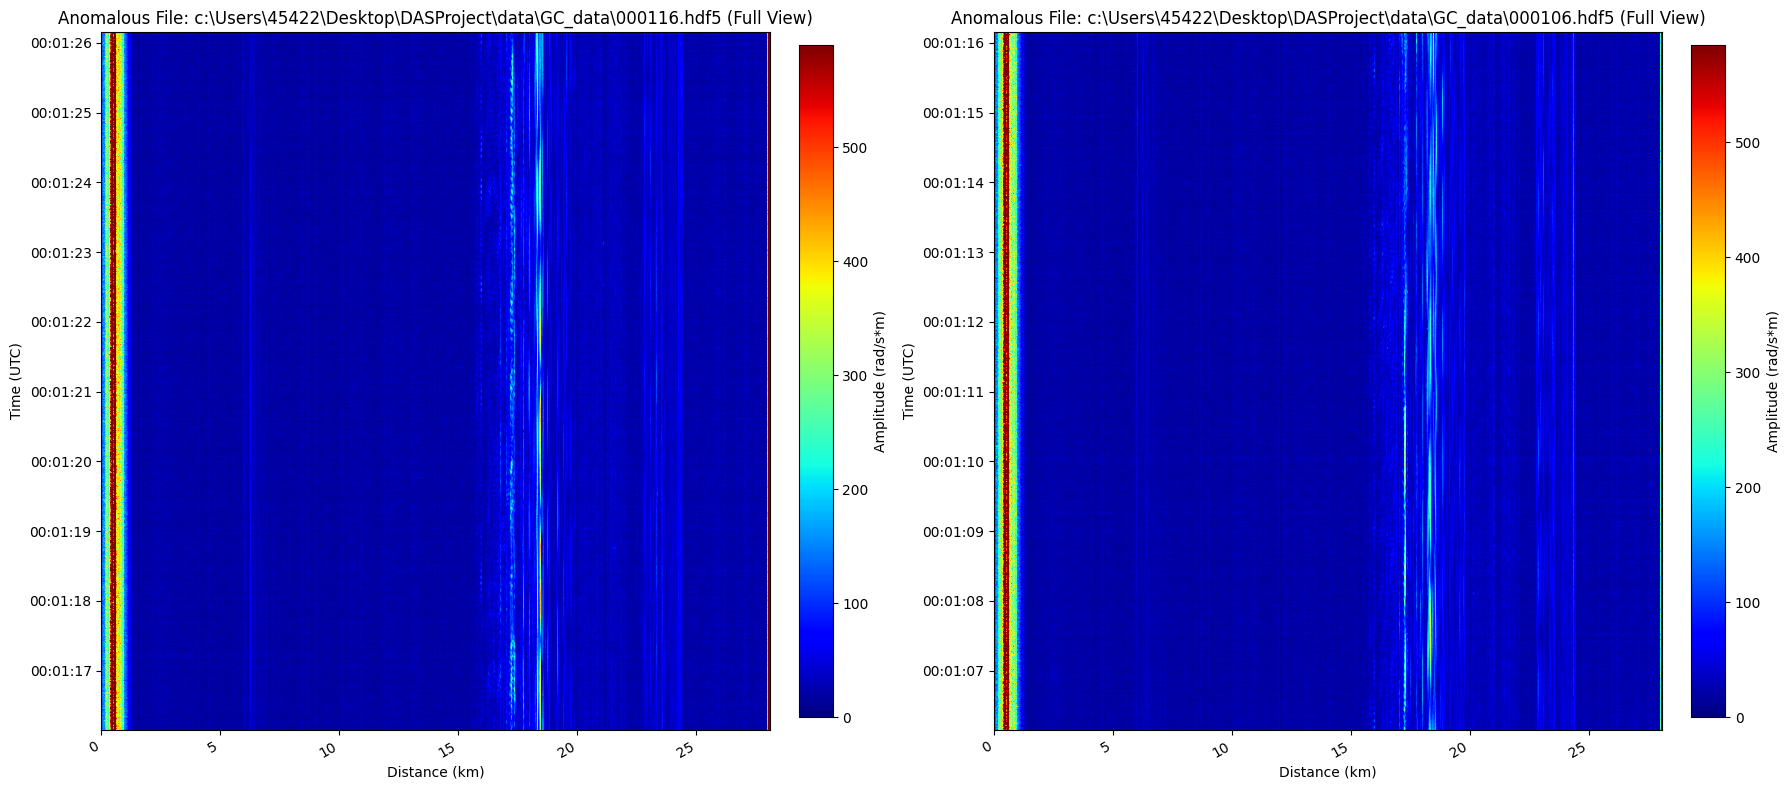

In [6]:
# Define the directory and relevant file names
directory = "data/GC_data"
random_samples = ['000116.hdf5', '000106.hdf5']  # The two most anomalous files

# Build absolute paths so extract_metadata always receives a full path
random_files = [os.path.abspath(os.path.join(directory, bn)) for bn in random_samples]

# Quick existence check
for p in random_files:
    if not os.path.exists(p):
        print(f"Warning: file not found: {p}")

# --- Configuration matching Step 1 ---
# These must match the preprocessing used for the model input
dmin_km = 0
dmax_km = 30 
CHANNEL_STEP = 2        # Sampling every second channel
SAMPLE_STEP = 1         # Temporal downsampling factor (no temporal downsampling applied)
dmin_km, dmax_km = 0, 30 
# Ensure we call extract_metadata with a full path and get dx (meters per channel)
first_path = random_files[0]
dx = extract_metadata(first_path)[2]  # Get actual dx

# --- Main Plotting Execution ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3)

# Plot File 1
plot_file_spectrogram(random_files[0], axes[0])

# Plot File 2
plot_file_spectrogram(random_files[1], axes[1])

plt.tight_layout()
plt.show() #
